In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

# Alphabets Setup

In [ ]:
# English Alphabet Set
# To enable us to write one hot encoded vectors for individual letters, and thus a vector-of-vectors representations of words, we give each letter in the alphabet a corresponding number
# Since transliteration is not case sensitive, we'll not include small letters in our letter-space
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# Since we want our input to be of uniform size, we need to define a 'pad' character to fill out smaller words
pad_char = '-PAD-'               

# Assigns each character a numerical value
eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
# Hindi Alphabet Set
# Hindi Unicode Hex Range is 2304:2432. (Source: https://sites.psu.edu/symbolcodes/languages/southasia/devanagari/devanagarichart/)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

# Helper Functions for Data Preprocessing

In [ ]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')    # Regex which returns all characters which are not small or capital letters, or spaces

# Function to remove all English non-letters from a line
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()    # Replaces hyphens and commas with spaces from line, so as to get spaces as the uniform delimiter
    line = non_eng_letters_regex.sub('', line)                 # Applies above regex on line, replacing every non-letter character with nothing
    return line.split()                                        # Splits the line by delimiter (space) into a list and returns it

# Function to remove all Hindi non-letters from a line
# Since we do not have defined regex for Hindi, we'll have to do the above process manually
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')            # Replaces hyphens and commas with spaces from line, so as to get spaces as the uniform delimiter
    # Builds a string by dropping any character which is not in the Devanagari script unicode range, and is not a space
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()                                # Splits the line by delimiter (space) into a list and returns it

## Dataset Loading

In [ ]:
from torch.utils.data import Dataset           # We import and extend the dataset class from torch, so we can use its functions while building our own dataset
import xml.etree.ElementTree as ET             # Library to work with XML files

# Class to define and instantiate a dataset
class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)    # Initializes the English and Hindi word sets from file using 'readXmlDataset()' function
        self.shuffle_indices = list(range(len(self.eng_words)))                              # Shuffles the indexes around for variance during training
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    # Function to return length of word    
    def __len__(self):
        return len(self.eng_words)
    
    # Function to return word from language words-list, given index
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    # Function to parse XML file to extract English and Hindi text words
    # An XML document data is hierarchical on purpose to enable easy parsing
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()    # Parses every root node (every point)
        lang1_words = []                                        # List of English words
        lang2_words = []                                        # List of Hindi words

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)         # The first tag of a node contains English text
            wordlist2 = lang_vocab_cleaner(line[1].text)        # The second tag of a node contains Hindi text

            # Skip noisy data
            # Any data where the length of the Englsh and Hindi strings doesn't match are outliers (with letters / sounds fused together) and are thus not considered
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)  
                continue

            # Pass the words of each language through respective pre-processing functions, and append the vector representation to the lists 
            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)
 
        return lang1_words, lang2_words                         # Returns list for both languages
    
    # Gets a sample random word from words-list by using the '__getitem__()' function
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    # Starts from a random index and loops over the whole array to gather 'batch_size' number of datapoints
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        # If the batch size from the chosen index exceeds the length of the array, we load the rest of the back by looping back to the start of the array
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    # Loads a data batch
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)       # Gets a random batch of some size for English words
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)   # Gets a random batch of some size for Hindi words
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch      

In [ ]:
# Applying above dataloader class onto uploaded XML files
# Training set has 13937 datapoints while Test set has 1000 datapoints
train_data = TransliterationDataLoader('/content/NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationDataLoader('/content/NEWS2012-Ref-EnHi-1000.xml')

In [ ]:
# Basic Data Visualization
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20641
Test Set Size:	 1000

Sample data from train-set:
TOIYABE - तोईयाबे
TOHDA - टोहड़ा
BELAGAAM - बेलगाम
HAMMAM - हमाम
IRFAN - इरफान
GEORGE - जॉर्ज
HOGA - होगा
AWRA - अव्रा
CHIRAAG - चिराग
VAASANTEE - वासंती


## Encoding The Words

In [ ]:
# This is for the input word, which is in Hindi
# Each word will be represented as a vector of one-hot encoded vectors
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

# This is for the output word, which is in English
# We shall treat this as a classification task, that is, each letter (one-hot encoded vector) from Hindi input is classified as one of 26 characters in the English alphabet
# Thus, the output representation is a vector of class labels
def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [ ]:
eng, hindi = train_data.get_random_sample()
hindi_rep = word_rep(hindi, hindi_alpha2index)
print(hindi, hindi_rep)

इंद्रायणी tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.]]])


In [ ]:
english_gt = gt_rep(eng, eng_alpha2index)
print(eng, english_gt)

INDRAYANI tensor([[ 9],
        [14],
        [ 4],
        [18],
        [ 1],
        [25],
        [ 1],
        [14],
        [ 9],
        [ 0]])


## Network Architecture

In [ ]:
# Encoder Decoder Model using GRUs with Attention Mechanism
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        # Size is increased, as hidden layer at decoder timestep will be augmented with the context vector
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        # Parameters for attention mechanism

        # Weight of encoder state vector from current timestep  (whose probability in the distribution is being computed)
        self.U = nn.Linear(self.hidden_size, self.hidden_size)                  
        # Weight of decoder state vector from previous timestamp
        self.W = nn.Linear(self.hidden_size, self.hidden_size)                  
        # Weight applied to the non-linearity applied to attention function (non-linearity applied to above two quantities)
        self.attn = nn.Linear(self.hidden_size, 1)
        # Linear layer converting decoder output at timestamp to size of hidden vector (since we will concatenate context vector with this quantity)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)            
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        # We resize the encoder output to be used in computing context vector
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)        
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        # Applying coefficient to encoder output
        U = self.U(encoder_outputs)
        
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        # Generating characters timestep by timestep
        for i in range(max_output_chars):
            
            # Applying coefficient to decoder state, and resizing for addition with encoder output
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            # Applying coefficient over the attention function, which in turn is a non-linearity over sum of encoder and decoder states
            V = self.attn(torch.tanh(U + W))
            # Applying softmax function over V to get a probability distribution
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            # Printing out the dimensions of the attention parameters
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            # Applying attention probability distribution as weights to the respective encoder outputs
            attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
            # Applying dimension transformation on decoder output from previous timestamp (to be passed as input to current timestamp)
            # This allows us to concatenate it with the context vector obtained from the attention mechanism
            embedding = self.out2hidden(decoder_input)
            # Concatenation decoder input and attention output to create the final input it to current timestamp of decoder
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            
            # Printing dimensions of context vector and new decoder input
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [ ]:
# Function to draw inference for a single word when passed through model
def infer(net, word, char_limit, device = 'cpu'):
    input = word_rep(word, hindi_alpha2index, device)    # Generates numerical representation of input word
    return net(input, char_limit)                      # Passes this representation to model

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index), verbose=True)

In [ ]:
# Dimensional inference
out = infer(net_attn, 'उसके', 30)

Encoder output torch.Size([5, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 27])
U * Encoder output torch.Size([5, 256])
W * Decoder state torch.Size([5, 256])
V torch.Size([5, 1])
Attn torch.Size([1, 5])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 27])


In [ ]:
# Running inference on above example (input 'INDIA') on untrained model
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 27]) ग
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ
torch.Size([1, 27]) अ


# Training

## Core Trainer

In [ ]:
# Function to execute training of model
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    # Pushing network to device
    net.train().to(device)
    # Setting all gradients to zero
    opt.zero_grad()
    # Getting a randomly generated batch of training input and output
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    # Iterating through batch
    for i in range(batch_size):
        
        # Numerical representation of English input
        input = word_rep(hindi_batch[i], hindi_alpha2index, device)
        # Numerical representation of the Hindi output
        gt = gt_rep(eng_batch[i], eng_alpha2index, device)
        # Calling model, with ground truth passed as additional parameter if teacher forcing (will be directly used during training)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        # Iterating through parameters output by model
        for index, output in enumerate(outputs):
            # Applying loss function
            loss = criterion(output, gt[index]) / batch_size
            # Computing gradients, 'retain_graph' parameter defines whether or not further training will be done to the model, which can be plotted accordingly on same graph
            loss.backward(retain_graph = True)
            # Aggregating loss
            total_loss += loss

    # Applying gradients at the end of batch
    opt.step()
    # Returns average loss across batch
    return total_loss/batch_size

## Training Helper

In [ ]:
# Function that sets up the hyperparameters for the training and calls the core training function with these hyperparameters
# It also plots the loss per iteration as a graph
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    # Creating network object and moving it to device
    net = net.to(device)
    # Defining loss function (cross-entropy loss here)
    criterion = nn.NLLLoss(ignore_index = -1)
    # Defining optimization function (Adam, here)
    opt = optim.Adam(net.parameters(), lr=lr)
    # Defining the number of batches for which teacher forcing will be carried out (here, it is for 1/3rd of the total batches)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    # Iterating over batches
    for i in range(n_batches):
        # Training function is called with defined hyperparameters, with teacher force value being conditional on batch number
        # Average loss after training on batch i is stored  
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        # Plots Iteration v Loss graph
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    # Checkpoints training for these parameters
    torch.save(net, 'model.pt')
    # Returns the stored losses of every batch as a list
    return loss_arr

## Training

In [ ]:
net = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index))

Iteration 499 Loss 0.1799733191728592


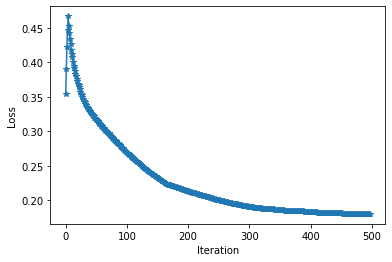

In [ ]:
loss_history = train_setup(net, lr=0.025, n_batches=500, batch_size = 64, display_freq=100, device = device_gpu)

# Inference

In [ ]:
# Function which draws inference for a given word using a given model
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    eng_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        eng_char = eng_alphabets[index+1]
        eng_output += eng_char
    print(word + ' - ' + eng_output)
    return eng_output

In [ ]:
# Function which gives accuracy of model given inference of the above 'test' function (which it calls) on the test data
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(eng, eng_alpha2index, device)
        outputs = infer(net, hindi, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            eng_pos = indices.tolist()[0]
            if eng_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [ ]:
accuracy = calc_accuracy(net) * 100
print('Accuracy : ', accuracy)

Accuracy :  51.02960146063088


In [ ]:
out = infer(net, 'उसके', 30)

In [ ]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(eng_alpha2index.keys())[list(eng_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 27]) O
torch.Size([1, 27]) S
torch.Size([1, 27]) K
torch.Size([1, 27]) E
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-


In [ ]:
print('keep_me_alive')

keep_me_alive
